# lasso regression 

In [1]:
# from:

#https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/ 

#https://medium.com/analytics-vidhya/lasso-regression-fundamentals-and-modeling-in-python-ad8251a636cd

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('/Users/bovandenbosch/Documents/Master_Applied Data_Science/Thesis/Data/df')
df = df.iloc[: , 1:]

In [4]:
#to reduce multicolinearty issues. We drop following. this corellated >0.7 all regions
df = df.drop(['dvoldt','Lmax','tstar_ela_h','debris_vol_ela_p','temp_mean_1980-2000','prcp_mean_1980_2000','Area','velocity_mean','ice_thickness'],axis=1)

# lasso HMA

In [5]:
dfa = df.drop(['O2Region','rgi_id'],axis=1)

In [6]:
numerical = dfa.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [7]:
y = dfa['dmdtda']
X = dfa.drop(['dmdtda'], axis=1)

In [8]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [10]:
from sklearn.linear_model import Lasso

#### explore alpha

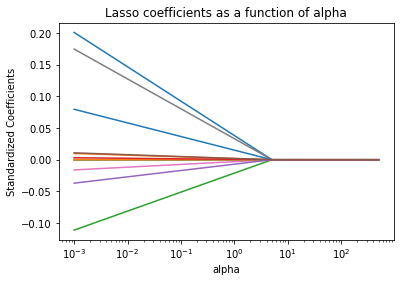

In [11]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [12]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [13]:
model.alpha_

0.5948076134065472

In [14]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.5948076134065472)

In [15]:
pd.Series(lasso_best.coef_.round(4), index = X_train.columns )

tstar_aar              0.0000
Slope                  0.0000
Zmed                   0.0002
Zmin                  -0.0002
Zmax                  -0.0000
debris_area_ela_p     -0.0000
temp_mean             -0.0000
temp_diff              0.0000
prcp_diff              0.0000
prcp_mean             -0.0000
temp_diff_1980-2000    0.0000
prcp_diff_1980_2000   -0.0001
glacial_lake          -0.0000
Aspect                -0.0000
Area_log              -0.0000
Velocity_log          -0.0000
dtype: float64

In [16]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 17.55
R squared test set 19.12


In [17]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.2076061625260725
MAE test set 0.20754642713636207


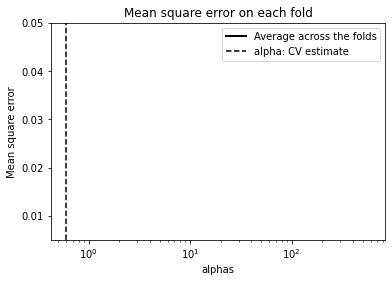

In [18]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

## per o2 region

In [19]:
rgi13 = gpd.read_file('/Users/bovandenbosch/Documents/Master_Applied Data_Science/Thesis/Data/RGI/nsidc0770_13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp')
rgi14 = gpd.read_file('/Users/bovandenbosch/Documents/Master_Applied Data_Science/Thesis/Data/RGI/nsidc0770_14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp')
rgi15 = gpd.read_file('/Users/bovandenbosch/Documents/Master_Applied Data_Science/Thesis/Data/RGI/nsidc0770_15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp')

In [20]:
# rgi_concat = pd.concat([rgi13,rgi14,rgi15],ignore_index=True)
rgi13 = rgi13.rename(columns={"RGIId": "rgi_id"})
rgi13 = rgi13[rgi13['Area'] > 2]
rgi13 = rgi13[['rgi_id']]
rgi13 = pd.DataFrame(rgi13)

rgi14 = rgi14.rename(columns={"RGIId": "rgi_id"})
rgi14 = rgi14[rgi14['Area'] > 2]
rgi14 = rgi14[['rgi_id']]
rgi14 = pd.DataFrame(rgi14)

rgi15 = rgi15.rename(columns={"RGIId": "rgi_id"})
rgi15 = rgi15[rgi15['Area'] > 2]
rgi15 = rgi15[['rgi_id']]
rgi15 = pd.DataFrame(rgi15)

In [21]:
df13 = df.merge(rgi13,on='rgi_id',how='inner')
df14 = df.merge(rgi14,on='rgi_id',how='inner')
df15 = df.merge(rgi15,on='rgi_id',how='inner')

In [22]:
df13_1 = df13[df13['O2Region'] == 1]
df13_2 = df13[df13['O2Region'] == 2]
df13_3 = df13[df13['O2Region'] == 3]
df13_4 = df13[df13['O2Region'] == 4]
df13_5 = df13[df13['O2Region'] == 5]
df13_6 = df13[df13['O2Region'] == 6]
df13_7 = df13[df13['O2Region'] == 7]
df13_8 = df13[df13['O2Region'] == 8]
df13_9 = df13[df13['O2Region'] == 9]

df14_1 = df14[df14['O2Region'] == 1]
df14_2 = df14[df14['O2Region'] == 2]
df14_3 = df14[df14['O2Region'] == 3]

df15_1 = df15[df15['O2Region'] == 1]
df15_2 = df15[df15['O2Region'] == 2]
df15_3 = df15[df15['O2Region'] == 3]

In [23]:
df13_1 = df13[df13['O2Region'] == 1].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df13_2 = df13[df13['O2Region'] == 2].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df13_3 = df13[df13['O2Region'] == 3].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df13_4 = df13[df13['O2Region'] == 4].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df13_5 = df13[df13['O2Region'] == 5].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df13_6 = df13[df13['O2Region'] == 6].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df13_7 = df13[df13['O2Region'] == 7].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df13_8 = df13[df13['O2Region'] == 8].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df13_9 = df13[df13['O2Region'] == 9].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums

df14_1 = df14[df14['O2Region'] == 1].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df14_2 = df14[df14['O2Region'] == 2].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df14_3 = df14[df14['O2Region'] == 3].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums

df15_1 = df15[df15['O2Region'] == 1].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df15_2 = df15[df15['O2Region'] == 2].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums
df15_3 = df15[df15['O2Region'] == 3].drop(['rgi_id','O2Region'],axis=1) #remove non numerical colums

# 13.1

### optimalize alpha
#### k-fold cross validation


In [24]:
df = df13_1

In [25]:
#nog extra drop per regio based on previous correlations 
df = df.drop(['temp_diff_1980-2000'],axis=1)

In [26]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [27]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [28]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [30]:
from sklearn.linear_model import Lasso

#### explore alpha

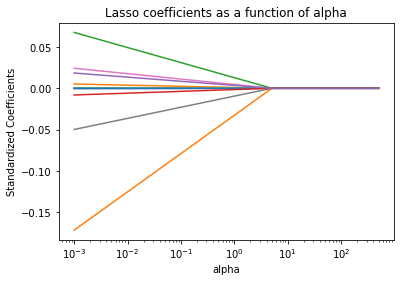

In [31]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [32]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [33]:
model.alpha_

0.21895972640494826

In [34]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.21895972640494826)

In [35]:
pd.Series(lasso_best.coef_.round(4), index = X_train.columns )

tstar_aar              0.0000
Slope                  0.0000
Zmed                   0.0003
Zmin                  -0.0001
Zmax                  -0.0001
debris_area_ela_p     -0.0000
temp_mean              0.0000
temp_diff             -0.0000
prcp_diff              0.0001
prcp_mean              0.0000
prcp_diff_1980_2000   -0.0002
glacial_lake          -0.0000
Aspect                 0.0000
Area_log              -0.0000
Velocity_log          -0.0000
dtype: float64

In [36]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 36.8
R squared test set -5.97


In [37]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.0934563048712083
MAE test set 0.13571503261693846


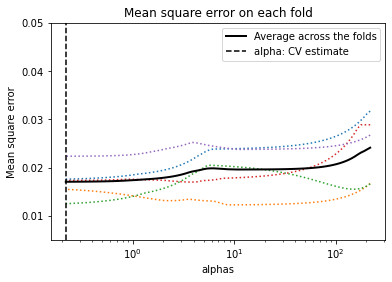

In [38]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 13.2

### optimalize alpha
#### k-fold cross validation


In [39]:
df = df13_2

In [40]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['prcp_mean'],axis=1)

In [41]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [42]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [43]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [45]:
from sklearn.linear_model import Lasso

#### explore alpha

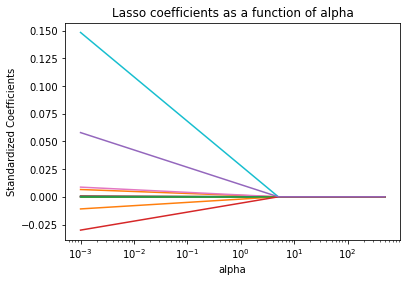

In [46]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [47]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [48]:
model.alpha_

0.02640147515387106

In [49]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.02640147515387106)

In [50]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar              0.000
Slope                  0.005
Zmed                   0.000
Zmin                  -0.000
Zmax                  -0.000
debris_area_ela_p      0.001
temp_mean              0.003
temp_diff             -0.000
prcp_diff             -0.000
temp_diff_1980-2000    0.000
prcp_diff_1980_2000    0.000
glacial_lake          -0.000
Aspect                -0.000
Area_log              -0.000
Velocity_log           0.000
dtype: float64

In [51]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 21.6
R squared test set 16.19


In [52]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.1082631897013217
MAE test set 0.10672702421936243


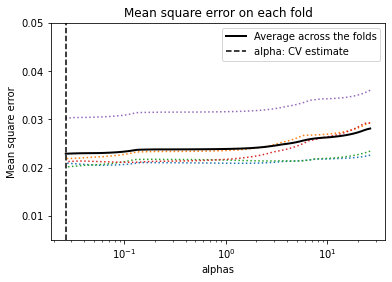

In [53]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 13.3

### optimalize alpha
#### k-fold cross validation


In [54]:
df = df13_3

In [55]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['prcp_mean','Velocity_log'],axis=1)

In [56]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [57]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [58]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [60]:
from sklearn.linear_model import Lasso

#### explore alpha

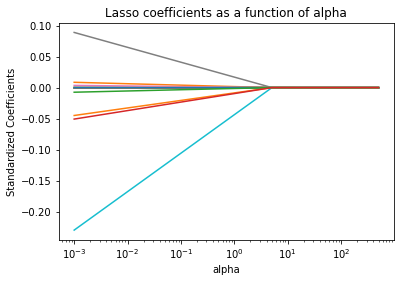

In [61]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [62]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [63]:
model.alpha_

0.04738109770371373

In [64]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.04738109770371373)

In [65]:
pd.Series(lasso_best.coef_.round(6), index = X_train.columns )

tstar_aar              0.000000
Slope                  0.010896
Zmed                   0.000377
Zmin                  -0.000040
Zmax                  -0.000005
debris_area_ela_p     -0.000285
temp_mean              0.000906
temp_diff              0.000000
prcp_diff              0.000043
temp_diff_1980-2000   -0.000000
prcp_diff_1980_2000   -0.000042
glacial_lake          -0.000000
Aspect                -0.000000
Area_log              -0.000000
dtype: float64

In [66]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 36.89
R squared test set 40.79


In [67]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.13538369819926838
MAE test set 0.12865459745330057


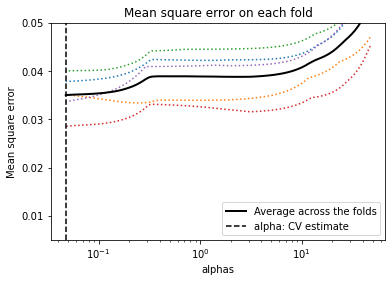

In [68]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 13.4

### optimalize alpha
#### k-fold cross validation


In [69]:
df = df13_4

In [70]:
#nog ectra drop per regio based on previous collerations 
#df = dniet nodgi

In [71]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [72]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [73]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [75]:
from sklearn.linear_model import Lasso

#### explore alpha

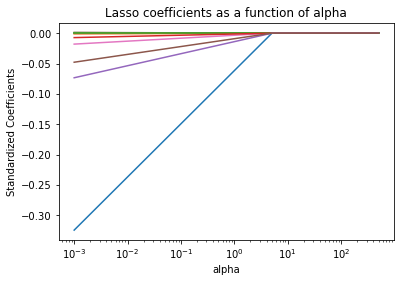

In [76]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [77]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [78]:
model.alpha_

0.24300764589106866

In [79]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.24300764589106866)

In [80]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar              0.000
Slope                  0.000
Zmed                   0.001
Zmin                  -0.000
Zmax                  -0.000
debris_area_ela_p      0.000
temp_mean             -0.000
temp_diff              0.000
prcp_diff             -0.000
prcp_mean              0.000
temp_diff_1980-2000   -0.000
prcp_diff_1980_2000    0.000
glacial_lake           0.000
Aspect                 0.000
Area_log              -0.000
Velocity_log          -0.000
dtype: float64

In [81]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 44.21
R squared test set 47.62


In [82]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.11798492848254255
MAE test set 0.10047695750693747


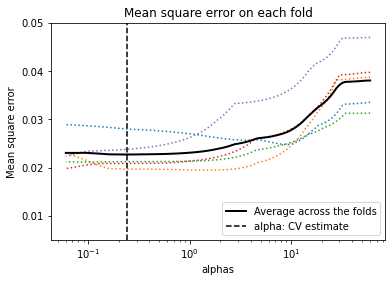

In [83]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 13.5

### optimalize alpha
#### k-fold cross validation


In [84]:
df = df13_5

In [85]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['prcp_diff','prcp_mean'],axis=1)

In [86]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [87]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [88]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [89]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [90]:
from sklearn.linear_model import Lasso

#### explore alpha

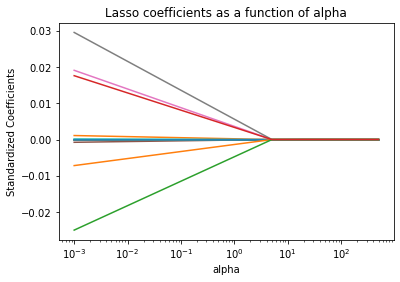

In [91]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [92]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [93]:
model.alpha_

0.02026026831703704

In [94]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.02026026831703704)

In [95]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar              0.000
Slope                  0.002
Zmed                   0.000
Zmin                  -0.000
Zmax                  -0.000
debris_area_ela_p     -0.001
temp_mean              0.015
temp_diff              0.000
temp_diff_1980-2000    0.000
prcp_diff_1980_2000    0.000
glacial_lake           0.000
Aspect                -0.000
Area_log              -0.000
Velocity_log           0.000
dtype: float64

In [96]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 27.54
R squared test set 24.64


In [97]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.09664291103170697
MAE test set 0.09239939086766777


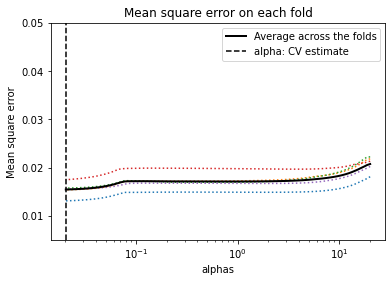

In [98]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 13.6

### optimalize alpha
#### k-fold cross validation


In [99]:
df = df13_6

In [100]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['prcp_diff_1980_2000'],axis=1)

In [101]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [102]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [103]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [104]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [105]:
from sklearn.linear_model import Lasso

#### explore alpha

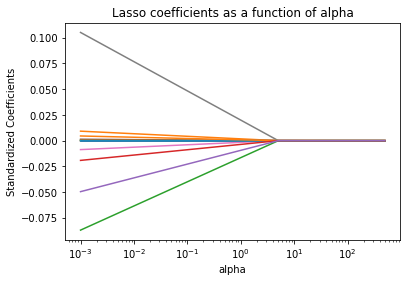

In [106]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [107]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [108]:
model.alpha_

0.040481215315296144

In [109]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.040481215315296144)

In [110]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar             -0.000
Slope                  0.013
Zmed                   0.000
Zmin                   0.000
Zmax                   0.000
debris_area_ela_p      0.001
temp_mean             -0.002
temp_diff              0.000
prcp_diff              0.000
prcp_mean             -0.000
temp_diff_1980-2000    0.000
glacial_lake          -0.000
Aspect                -0.000
Area_log              -0.000
Velocity_log          -0.000
dtype: float64

In [111]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 41.25
R squared test set 45.03


In [112]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.10521014761093248
MAE test set 0.09854213967590814


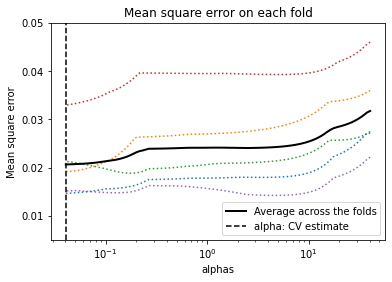

In [113]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 13.7

### optimalize alpha
#### k-fold cross validation


In [114]:
df = df13_7

In [115]:
#nog ectra drop per regio based on previous collerations 
#df = 

In [116]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [117]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [118]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [119]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [120]:
from sklearn.linear_model import Lasso

#### explore alpha

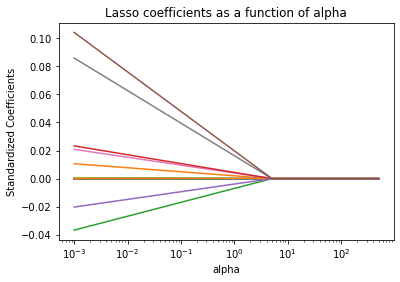

In [121]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [122]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [123]:
model.alpha_

0.35116973357071213

In [124]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.35116973357071213)

In [125]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar              0.0
Slope                  0.0
Zmed                   0.0
Zmin                  -0.0
Zmax                  -0.0
debris_area_ela_p     -0.0
temp_mean              0.0
temp_diff             -0.0
prcp_diff              0.0
prcp_mean             -0.0
temp_diff_1980-2000   -0.0
prcp_diff_1980_2000   -0.0
glacial_lake          -0.0
Aspect                 0.0
Area_log              -0.0
Velocity_log           0.0
dtype: float64

In [126]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 42.35
R squared test set 53.24


In [127]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.09218198549066875
MAE test set 0.08902482868155207


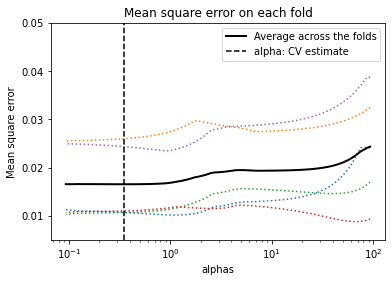

In [128]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 13.8

### optimalize alpha
#### k-fold cross validation


In [129]:
df = df13_8

In [130]:
#nog ectra drop per regio based on previous collerations 
#df = 

In [131]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [132]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [133]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [134]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [135]:
from sklearn.linear_model import Lasso

#### explore alpha

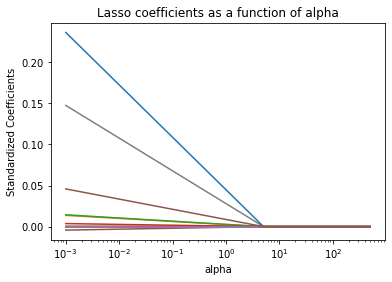

In [136]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [137]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [138]:
model.alpha_

0.2535973820754196

In [139]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.2535973820754196)

In [140]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar             -0.000
Slope                  0.000
Zmed                   0.001
Zmin                  -0.000
Zmax                   0.000
debris_area_ela_p     -0.000
temp_mean             -0.000
temp_diff              0.000
prcp_diff             -0.000
prcp_mean             -0.000
temp_diff_1980-2000    0.000
prcp_diff_1980_2000   -0.000
glacial_lake          -0.000
Aspect                 0.000
Area_log              -0.000
Velocity_log           0.000
dtype: float64

In [141]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 43.46
R squared test set 43.59


In [142]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.15328460671747487
MAE test set 0.14328289188999935


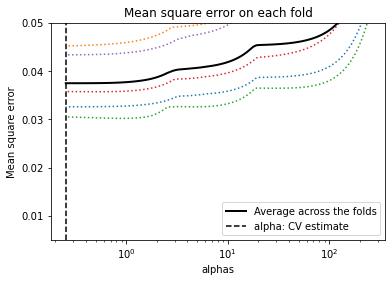

In [143]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 13.9

### optimalize alpha
#### k-fold cross validation


In [144]:
df = df13_9

In [145]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['prcp_diff','prcp_mean','prcp_diff_1980_2000'],axis=1)

In [146]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [147]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [148]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [149]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [150]:
from sklearn.linear_model import Lasso

#### explore alpha

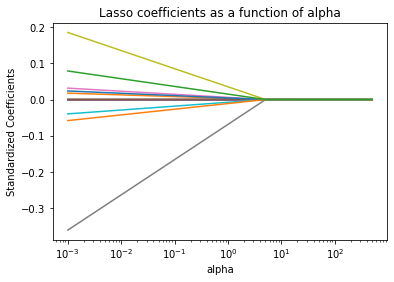

In [151]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [152]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [153]:
model.alpha_

0.02894476948853615

In [154]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.02894476948853615)

In [155]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar              0.000
Slope                  0.017
Zmed                   0.001
Zmin                  -0.000
Zmax                   0.000
debris_area_ela_p     -0.000
temp_mean              0.027
temp_diff             -0.000
temp_diff_1980-2000    0.000
glacial_lake          -0.000
Aspect                 0.000
Area_log              -0.000
Velocity_log           0.000
dtype: float64

In [156]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 30.75
R squared test set -1.46


In [157]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.19608372846161967
MAE test set 0.23551824155448578


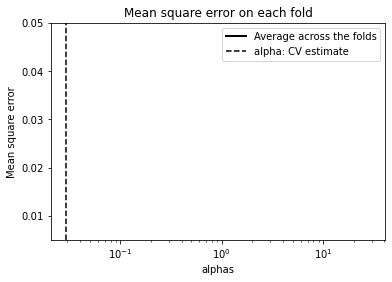

In [158]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 14.1

### optimalize alpha
#### k-fold cross validation


In [159]:
df = df14_1

In [160]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['prcp_mean','Velocity_log'],axis=1)

In [161]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [162]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [163]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [164]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [165]:
from sklearn.linear_model import Lasso

#### explore alpha

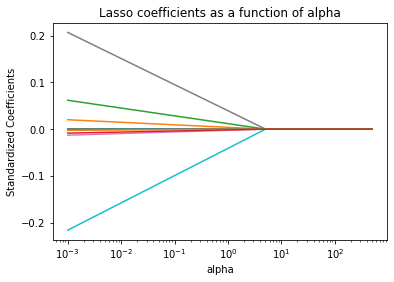

In [166]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [167]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [168]:
model.alpha_

0.049234160183855256

In [169]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.049234160183855256)

In [170]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar             -0.000
Slope                  0.018
Zmed                   0.000
Zmin                  -0.000
Zmax                   0.000
debris_area_ela_p      0.000
temp_mean             -0.000
temp_diff              0.000
prcp_diff             -0.000
temp_diff_1980-2000   -0.000
prcp_diff_1980_2000   -0.000
glacial_lake          -0.000
Aspect                 0.000
Area_log              -0.000
dtype: float64

In [171]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 42.44
R squared test set 47.35


In [172]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.115659520800621
MAE test set 0.10144896661460334


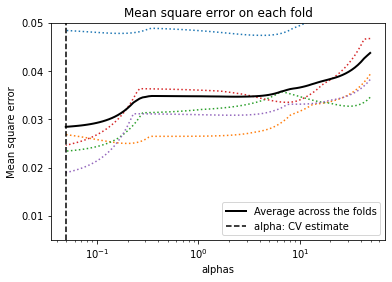

In [173]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 14.2

### optimalize alpha
#### k-fold cross validation


In [174]:
df = df14_2

In [175]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['Velocity_log'],axis=1)

In [176]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [177]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [178]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [179]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [180]:
from sklearn.linear_model import Lasso

#### explore alpha

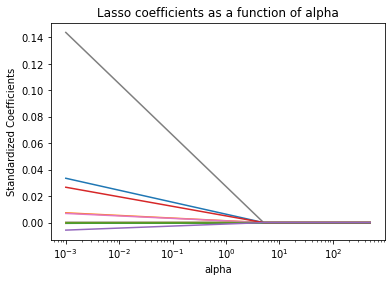

In [181]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [182]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [183]:
model.alpha_

0.032341918518264914

In [184]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.032341918518264914)

In [185]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar              0.000
Slope                  0.006
Zmed                  -0.000
Zmin                  -0.000
Zmax                  -0.000
debris_area_ela_p     -0.001
temp_mean              0.002
temp_diff              0.000
prcp_diff             -0.000
prcp_mean             -0.000
temp_diff_1980-2000    0.000
prcp_diff_1980_2000   -0.000
glacial_lake          -0.000
Aspect                 0.000
Area_log              -0.000
dtype: float64

In [186]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 11.53
R squared test set 16.64


In [187]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.10757003752885257
MAE test set 0.10625877310005462


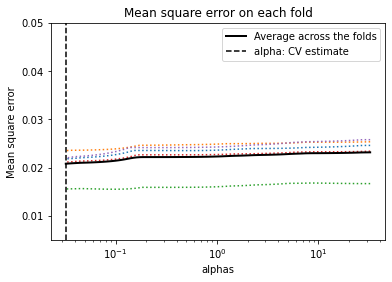

In [188]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 14.3

### optimalize alpha
#### k-fold cross validation


In [189]:
df = df14_3

In [190]:
#nog ectra drop per regio based on previous collerations 
# df = 

In [191]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [192]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [193]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [194]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [195]:
from sklearn.linear_model import Lasso

#### explore alpha

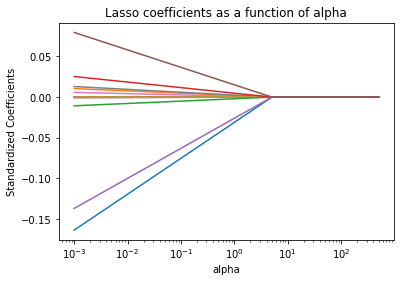

In [196]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [197]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [198]:
model.alpha_

0.09076090207889267

In [199]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.09076090207889267)

In [200]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar              0.000
Slope                  0.012
Zmed                   0.000
Zmin                  -0.000
Zmax                   0.000
debris_area_ela_p     -0.001
temp_mean              0.000
temp_diff              0.000
prcp_diff             -0.000
prcp_mean              0.000
temp_diff_1980-2000   -0.000
prcp_diff_1980_2000   -0.000
glacial_lake          -0.000
Aspect                 0.000
Area_log              -0.000
Velocity_log           0.000
dtype: float64

In [201]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 27.68
R squared test set 27.07


In [202]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.12907950871809298
MAE test set 0.14459119056705622


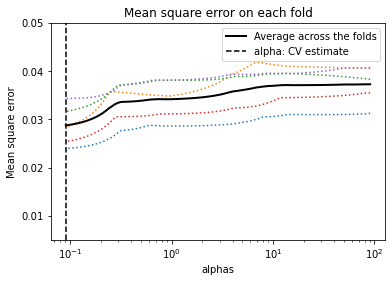

In [203]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 15.1

### optimalize alpha
#### k-fold cross validation


In [204]:
df = df15_1

In [205]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['prcp_mean'],axis=1)

In [206]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [207]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [208]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [209]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [210]:
from sklearn.linear_model import Lasso

#### explore alpha

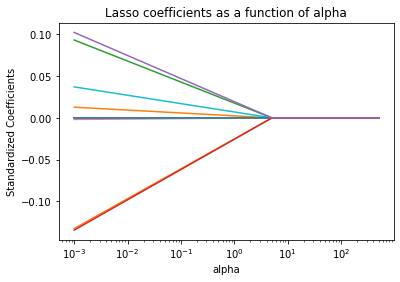

In [211]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [212]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [213]:
model.alpha_

0.06392874018073749

In [214]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.06392874018073749)

In [215]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar              0.000
Slope                  0.012
Zmed                   0.000
Zmin                  -0.000
Zmax                  -0.000
debris_area_ela_p     -0.000
temp_mean              0.000
temp_diff              0.000
prcp_diff              0.000
temp_diff_1980-2000    0.000
prcp_diff_1980_2000   -0.000
glacial_lake          -0.000
Aspect                 0.000
Area_log              -0.000
Velocity_log           0.000
dtype: float64

In [216]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 28.41
R squared test set 31.52


In [217]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.17274224986346795
MAE test set 0.17752167988873685


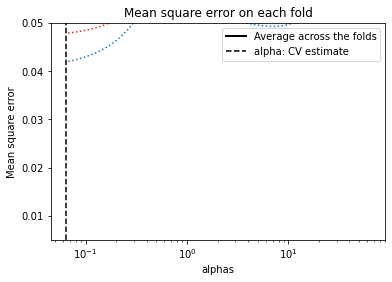

In [218]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 15.2

### optimalize alpha
#### k-fold cross validation


In [219]:
df = df15_2

In [220]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['Zmed','prcp_mean','temp_diff_1980-2000'],axis=1)

In [221]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [222]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [223]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [224]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [225]:
from sklearn.linear_model import Lasso

#### explore alpha

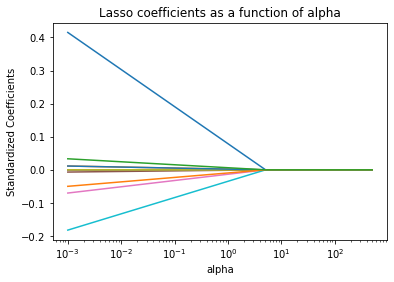

In [226]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [227]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [228]:
model.alpha_

0.054498925298279946

In [229]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.054498925298279946)

In [230]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar              0.000
Slope                  0.013
Zmin                  -0.000
Zmax                   0.000
debris_area_ela_p     -0.002
temp_mean             -0.000
temp_diff             -0.000
prcp_diff             -0.000
prcp_diff_1980_2000   -0.000
glacial_lake          -0.000
Aspect                 0.000
Area_log              -0.000
Velocity_log          -0.000
dtype: float64

In [231]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 32.73
R squared test set 17.21


In [232]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.16831129186872762
MAE test set 0.16768459824532217


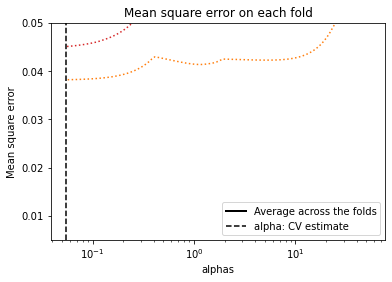

In [233]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);

# 15.3

### optimalize alpha
#### k-fold cross validation


In [234]:
df = df15_3

In [235]:
#nog ectra drop per regio based on previous collerations 
df = df.drop(['prcp_diff_1980_2000'],axis=1)

In [236]:
numerical = df.drop(['glacial_lake','Aspect'], axis=1)
list_numerical = numerical.columns

In [237]:
y = df['dmdtda']
X = df.drop(['dmdtda'], axis=1)

In [238]:
# make train en test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [239]:
#making a zscore
x_list_numerical = list_numerical.drop(['dmdtda'])

X_train_z = (X_train[x_list_numerical] - X_train[x_list_numerical].mean())/X_train[x_list_numerical].std()
X_train_z = pd.concat([X_train_z, X_train['glacial_lake']], axis=1)
X_train_z = pd.concat([X_train_z, X_train['Aspect']], axis=1)

X_test_z = (X_test[x_list_numerical] - X_test[x_list_numerical].mean())/X_test[x_list_numerical].std()
X_test_z = pd.concat([X_test_z, X_test['glacial_lake']], axis=1)
X_test_z = pd.concat([X_test_z, X_test['Aspect']], axis=1)

### Lasso

In [240]:
from sklearn.linear_model import Lasso

#### explore alpha

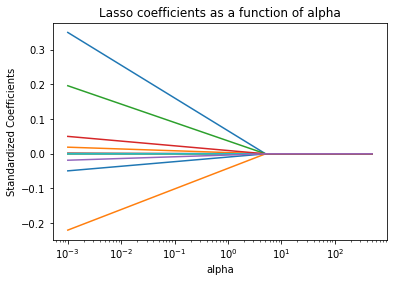

In [241]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.001,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### optimalize alpha
#### k-fold cross validation


In [242]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=42, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [243]:
model.alpha_

16.60885722496001

In [244]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=16.60885722496001)

In [245]:
pd.Series(lasso_best.coef_.round(3), index = X_train.columns )

tstar_aar             -0.0
Slope                  0.0
Zmed                  -0.0
Zmin                  -0.0
Zmax                  -0.0
debris_area_ela_p      0.0
temp_mean              0.0
temp_diff             -0.0
prcp_diff              0.0
prcp_mean              0.0
temp_diff_1980-2000   -0.0
glacial_lake          -0.0
Aspect                 0.0
Area_log              -0.0
Velocity_log          -0.0
dtype: float64

In [246]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 7.27
R squared test set 9.89


In [247]:
from sklearn.metrics import mean_absolute_error
print('MAE train set',mean_absolute_error(y_train, lasso_best.predict(X_train)))
print('MAE test set',mean_absolute_error(y_test, lasso_best.predict(X_test)))

MAE train set 0.30447460717180497
MAE test set 0.29274569845644294


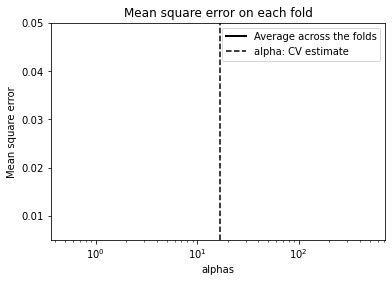

In [248]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.005, 0.05
plt.ylim(ymin, ymax);